### Reading the File Data

In [1]:
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, box
import pandas as pd
import geopandas as gpd
import numpy as np
from collections import defaultdict
from math import isclose
import matplotlib.pyplot as plt

# NUMBER OF DATA POINTS
NUM_DATA_POINTS = 100000

def remove_duplicates(gdf):
    gdf_temp = gdf.iloc[:, 1:].copy()
    gdf_temp = gdf_temp.drop(columns=['Error'])
    dup_mask = gdf_temp.duplicated(keep='first')

    gdf_res = gdf[~dup_mask]
    gdf_res.loc[:, 'Error'] = gdf_res['Error'].apply(
        lambda x: 0 if x == 2 else x)
    return gdf_res

print('Reading Shapefile...')

# Load the shapefile
points_shapefile_path = '.\\GTAA_Errors_Intersection'
points_gdf = gpd.read_file(points_shapefile_path)

print(points_gdf.head(3))

lines_shapefile_path = '.\\GTAA_errors'
lines_gdf = gpd.read_file(lines_shapefile_path)


lines_gdf = remove_duplicates(lines_gdf)
print("Duplicates Removed")

print('Exploding Shapefiles...')
# exploding
points_gdf = points_gdf.explode(index_parts=True).reset_index()
lines_gdf = lines_gdf.explode(index_parts=True).reset_index()

points_gdf = points_gdf.reset_index()
lines_gdf = lines_gdf.reset_index()

points_gdf['id'] = points_gdf['index']
lines_gdf['id'] = lines_gdf['index']

Reading Shapefile...
   Id                            geometry
0   0  POINT Z (611548.567 4838056.456 0)
1   0   POINT Z (611541.452 4838058.75 0)
2   0    POINT Z (611547.63 4838074.62 0)
Duplicates Removed
Exploding Shapefiles...


### Computing Intersection to Line Mappings

In [2]:
# Step 1: Use spatial index to find intersecting line pairs
intersections = []
intersection_to_lines_map = defaultdict(set)
line_to_intersections_map = defaultdict(set)

sindex = lines_gdf.sindex  # spatial index for fast lookup


print('Computing Intersections')
for idx1, geom1 in lines_gdf.geometry.items():
    # Get possible matches using bounding box
    possible_matches_index = list(sindex.intersection(geom1.bounds))

    for idx2 in possible_matches_index:
        if idx1 >= idx2:
            continue  # Skip self and duplicate comparisons

        geom2 = lines_gdf.geometry.iloc[idx2]
        inter = geom1.intersection(geom2)

        if inter.is_empty:
            continue

        if inter.geom_type == "Point":
            inter_points = [inter]
        elif inter.geom_type == "MultiPoint":
            inter_points = list(inter.geoms)
        else:
            continue

        for pt in inter_points:
            # Normalize point (for hashing) by rounding coords
            rounded_pt = Point(round(pt.x, 8), round(pt.y, 8))
            intersections.append(rounded_pt)

            # Fill both maps
            intersection_to_lines_map[rounded_pt].update([idx1, idx2])
            line_to_intersections_map[idx1].add(rounded_pt)
            line_to_intersections_map[idx2].add(rounded_pt)

    if idx1 % 250 == 0:
        print('Done', idx1, len(intersections))

    if (idx1 + 1) % NUM_DATA_POINTS == 0:
        break

intersections = list(intersection_to_lines_map.keys())
print('Done Computing Intersections', len(intersections))
# Step 2: Deduplicate intersection points
unique_intersections = gpd.GeoSeries(intersections).drop_duplicates()
print('Done Removing Duplicates', unique_intersections.shape)

# Create GeoDataFrame for intersections
intersections_gdf = gpd.GeoDataFrame(
    geometry=unique_intersections.reset_index(drop=True), crs=points_gdf.crs)

# Make sure CRS matches
assert points_gdf.crs == intersections_gdf.crs


Computing Intersections
Done 0 8
Done 250 2439
Done 500 2570
Done 750 2813
Done 1000 3359
Done 1250 3780
Done 1500 4099
Done 1750 4553
Done 2000 4855
Done 2250 5312
Done 2500 5738
Done 2750 6398
Done 3000 6954
Done 3250 7384
Done 3500 7836
Done 3750 8562
Done 4000 9334
Done 4250 9584
Done 4500 9961
Done 4750 10629
Done 5000 10876
Done 5250 11337
Done 5500 11776
Done 5750 12307
Done 6000 12932
Done 6250 13617
Done 6500 14099
Done 6750 14567
Done 7000 15407
Done 7250 15778
Done 7500 15920
Done 7750 16025
Done 8000 16304
Done 8250 16574
Done 8500 16729
Done 8750 17137
Done 9000 17506
Done 9250 17760
Done 9500 17795
Done 9750 17908
Done 10000 17936
Done 10250 17958
Done 10500 17974
Done 10750 18022
Done 11000 18044
Done 11250 18074
Done 11500 18118
Done 11750 18168
Done 12000 18203
Done 12250 18258
Done 12500 18289
Done 12750 18340
Done 13000 18383
Done 13250 18406
Done 13500 18448
Done 13750 18483
Done 14000 18516
Done 14250 18621
Done 14500 18684
Done 14750 18804
Done 15000 19197
Done 15

### Visualizing / Experimenting with the Data

In [3]:
def scale_points_and_gdf_to_100(point_list, gdf, intersection_to_lines_map):
    # Gather all x and y values from point list and gdf
    xs = [pt.x for pt in point_list] + [geom.x for geom in gdf.geometry]
    ys = [pt.y for pt in point_list] + [geom.y for geom in gdf.geometry]

    # Get global min and max
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    def scale_linestrings(gdf, min_x, max_x, min_y, max_y, target_min=0, target_max=100):
        """
        Scale the x and y coordinates of LineString geometries to a target range.
        
        :param gdf: GeoDataFrame containing the LineString geometries.
        :param min_x: Minimum x coordinate of the bounding box.
        :param max_x: Maximum x coordinate of the bounding box.
        :param min_y: Minimum y coordinate of the bounding box.
        :param max_y: Maximum y coordinate of the bounding box.
        :param target_min: The minimum value of the target range (default is 0).
        :param target_max: The maximum value of the target range (default is 100).
        :return: GeoDataFrame with scaled LineString geometries.
        """
        
        # Function to scale the coordinates of a line to the target range
        def scale_line(line):            
            # Scale the x and y coordinates
            scaled_coords = []
            for x, y, z in line.coords:
                scaled_x = target_min + \
                    (x - min_x) * (target_max - target_min) / (max_x - min_y)
                scaled_y = target_min + \
                    (y - min_y) * (target_max - target_min) / (max_y - min_y)
                scaled_coords.append((scaled_x, scaled_y))
            
            # Return a new scaled LineString
            return LineString(scaled_coords)
        
        # Apply the scaling to each LineString in the GeoDataFrame
        gdf['geometry'] = gdf['geometry'].apply(scale_line)
        
        return gdf
    
    scaled_lines_gdf = scale_linestrings(lines_gdf, min_x, max_x, min_y, max_y)

    range_x = max_x - min_x if max_x != min_x else 1
    range_y = max_y - min_y if max_y != min_y else 1

    # Scale gdf geometry
    new_line_to_intersections_map = defaultdict(set)
    new_intersection_to_lines_map = defaultdict(set)
    scaled_points = []
    for pt in intersections:
        new_pt = Point((pt.x - min_x) / range_x * 100,
                   (pt.y - min_y) / range_y * 100)
        rounded_pt = Point(round(new_pt.x, 8), round(new_pt.y, 8))
        new_intersection_to_lines_map[rounded_pt] = intersection_to_lines_map[pt]
        scaled_points.append(rounded_pt)

        for line in new_intersection_to_lines_map[rounded_pt]:
            new_line_to_intersections_map[line].add(rounded_pt)

    # Scale gdf geometry
    scaled_geometries = [
        Point((geom.x - min_x) / range_x * 100, (geom.y - min_y) / range_y * 100)
        for geom in gdf.geometry
    ]
    scaled_gdf = gdf.set_geometry(scaled_geometries)

    return scaled_points, scaled_gdf, new_intersection_to_lines_map, new_line_to_intersections_map, scaled_lines_gdf


scaled_intersections, scaled_points_gdf, new_intersection_to_lines_map, new_line_to_intersections_map, scaled_lines_gdf = scale_points_and_gdf_to_100(
    intersections, points_gdf, intersection_to_lines_map)
print(new_intersection_to_lines_map)

defaultdict(<class 'set'>, {<POINT (30.113 81.904)>: {0, np.int64(20), 4}, <POINT (30.114 81.904)>: {0, np.int64(19), 4}, <POINT (30.134 81.924)>: {0, np.int64(19), 4}, <POINT (30.129 81.915)>: {0, 4, np.int64(53965)}, <POINT (30.109 81.903)>: {0, np.int64(1), np.int64(4), np.int64(5)}, <POINT (30.136 81.932)>: {0, np.int64(3), np.int64(4), np.int64(7)}, <POINT (30.088 81.932)>: {1, np.int64(2), np.int64(5), np.int64(6)}, <POINT (30.088 81.939)>: {2, np.int64(20), 6}, <POINT (30.088 81.941)>: {2, np.int64(19), 6}, <POINT (30.109 81.961)>: {2, np.int64(3), np.int64(6), np.int64(7), np.int64(19)}, <POINT (30.098 81.959)>: {2, np.int64(53965), 6}, <POINT (30.693 81.124)>: {8, np.int64(9)}, <POINT (30.731 81.07)>: {8, np.int64(22)}, <POINT (30.802 80.962)>: {8, np.int64(53965)}, <POINT (30.39 81.512)>: {9, np.int64(20)}, <POINT (30.388 81.51)>: {9, np.int64(19)}, <POINT (30.41 81.532)>: {9, np.int64(19)}, <POINT (30.446 81.574)>: {9, np.int64(23)}, <POINT (30.716 81.19)>: {9, np.int64(23)}

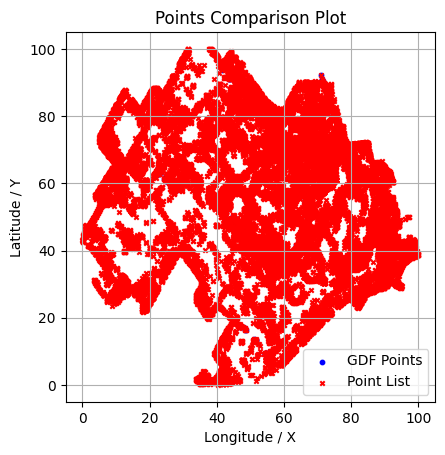

In [4]:
def convert_3d_to_2d(gdf):
    new_geoms = []
    for geom in gdf.geometry:
        if isinstance(geom, Point):
            coords = geom.coords[0]
            if len(coords) == 3:
                new_geoms.append(Point(coords[0], coords[1]))  # Drop Z
            else:
                new_geoms.append(geom)  # Already 2D
        else:
            new_geoms.append(geom)  # Leave non-Point geometry unchanged
    return gdf.set_geometry(new_geoms)

points_gdf_2d = convert_3d_to_2d(scaled_points_gdf)


def plot_points(point_list, points_gdf, point_list_color='red', gdf_color='blue', point_size=10):
    # Convert list of Points into a GeoDataFrame
    point_list_gdf = gpd.GeoDataFrame(geometry=point_list, crs=points_gdf.crs)

    # Plot both on the same figure
    ax = points_gdf.plot(marker='o', color=gdf_color,
                         markersize=point_size, label='GDF Points')
    point_list_gdf.plot(ax=ax, marker='x', color=point_list_color,
                        markersize=point_size, label='Point List')

    plt.legend()
    plt.xlabel("Longitude / X")
    plt.ylabel("Latitude / Y")
    plt.title("Points Comparison Plot")
    plt.grid(True)
    plt.show()


plot_points(scaled_intersections, points_gdf_2d)

In [79]:
from shapely.geometry import Point
import geopandas as gpd


def map_points_to_existence_with_sindex(point_list, gdf, tolerance=3e-3):
    # Create spatial index for faster searching
    sindex = gdf.sindex

    # Create a mapping from each Point to binary (1 if exists in gdf, 0 otherwise)
    point_map = {}

    for pt in point_list:
        # Use spatial index to find potential matching geometries by bounding box
        possible_matches_index = list(sindex.nearest(pt))

        # Check if the point exists in any of the geometries
        # If tolerance > 0, we check the distance between points instead of exact match
        found = False
        for idx in possible_matches_index:
            geom = gdf.iloc[idx].geometry.iloc[0]
            dist_value = pt.distance(geom)
            if tolerance > 0 and dist_value <= tolerance:
                found = True
                break

        point_map[pt] = 1 if found else 0

    return point_map    

# Mapping with exact match
point_map = map_points_to_existence_with_sindex(scaled_intersections, points_gdf_2d, tolerance=5e-3)

intersections_2d = scaled_intersections

# Mapping with tolerance (e.g. 0.001 units)
# point_map = map_points_to_existence(point_list, gdf, tolerance=0.001)
matches_count = sum(list(point_map.values()))
print(f'Found {matches_count} matches out of {len(point_map)} points')

Found 455 matches out of 72021 points


<Figure size 240000x240000 with 0 Axes>

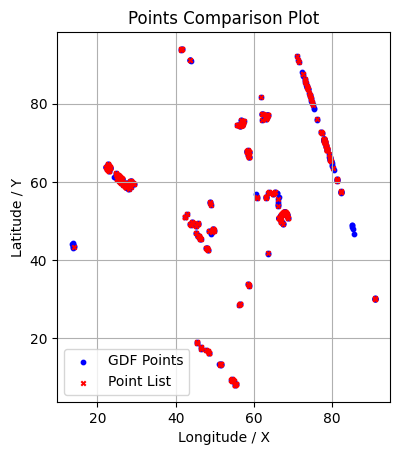

In [80]:
points = [el for el in list(point_map.keys()) if point_map[el] == 1]
plt.figure(figsize=(2400, 2400))
plot_points(points, points_gdf_2d)


### Computing Feature Metrics

#### Metric Helper Methods

In [55]:
from collections import deque, defaultdict
import math
import heapq
import numpy as np
from shapely.geometry import Point, LineString
from math import isclose


def to_vec2(coords):
    """Ensure a coordinate tuple has exactly 2 elements (x, y)."""
    return np.array(coords[:2])  # Only use x, y for 2D points


def line_angle_vec_2d(line: LineString) -> np.ndarray:
    """Return the normalized direction vector of a line in 2D."""
    if len(line.coords) < 2:
        return np.array([0.0, 0.0])
    start = to_vec2(line.coords[0])
    end = to_vec2(line.coords[-1])
    vec = end - start
    norm = np.linalg.norm(vec)
    return vec / norm if norm != 0 else vec


def angle_between_vectors_2d(v1, v2):
    """Angle in radians between two 2D vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if isclose(norm_product, 0.0):
        return 0.0
    cos_theta = np.clip(dot_product / norm_product, -1.0, 1.0)
    return np.arccos(cos_theta)


def dist_2d(p1: Point, p2: Point) -> float:
    """Compute 2D distance between two shapely points."""
    return np.linalg.norm(to_vec2(p1.coords[0]) - to_vec2(p2.coords[0]))


def weighted_avg_dist_2d(intersection, other_points):
    """Weighted average of 2D distances to other intersections."""
    dists = np.array([dist_2d(intersection, pt)
                     for pt in other_points if not pt.equals(intersection)])
    if len(dists) == 0:
        return 0.0
    weights = 1 / (dists + 1e-4)
    return np.average(dists, weights=weights)


def get_bbox_dimensions_2d(lines):
    """2D bounding box dimensions from a group of lines."""
    all_coords = [coord for line in lines for coord in line.coords]
    arr = np.array(all_coords)
    if arr.shape[0] == 0:
        return 0.0, 0.0
    ymin, ymax = arr[:, 1].min(), arr[:, 1].max()
    xmin, xmax = arr[:, 0].min(), arr[:, 0].max()
    height = ymax - ymin
    width = xmax - xmin
    return height, width


points_gdf_sindex = points_gdf_2d.sindex

def point_exists_within_tolerance_2d(pt, tolerance=3e-3):
    possible_matches_index = list(points_gdf_sindex.nearest(pt))

    # Check if the point exists in any of the geometries
    # If tolerance > 0, we check the distance between points instead of exact match
    found = False
    for idx in possible_matches_index:
        geom = points_gdf_2d.iloc[idx].geometry.iloc[0]
        dist_value = pt.distance(geom)
        if tolerance > 0 and dist_value <= tolerance:
            found = True
            break
    return found


def find_nearby_points(query_point, str_tree, buffer_size=0.1):
    return str_tree[query_point]

def find_optimized_loops(start, new_line_to_intersections_map, new_intersection_to_lines_map, line_to_spatial_index, max_depth=5):
    def distance(p1, p2):
        if (p1, p2) not in dist_cache:
            dist_cache[(p1, p2)] = dist_cache[(p2, p1)] = math.hypot(
                p1.x - p2.x, p1.y - p2.y)
        return dist_cache[(p1, p2)]

    shortest_perimeter = float('inf')
    dist_cache = {}
    found_loop = False

    # Use a queue of (current_point, path_so_far, perimeter)
    queue = deque()
    queue.append((start, [start], 0.0))

    while queue:
        current, path, perimeter = queue.popleft()

        if len(path) > max_depth:
            continue

        for line in new_intersection_to_lines_map.get(current, []):
            neighbors = find_nearby_points(
                current, line_to_spatial_index[line])

            # Only explore top 3 closest points
            for neighbor in neighbors[:4]:
                if neighbor == start and len(path) >= 3:
                    total_perimeter = perimeter + distance(current, start)
                    if total_perimeter < shortest_perimeter:
                        shortest_perimeter = total_perimeter
                        found_loop = True
                elif neighbor not in path:
                    new_perimeter = perimeter + distance(current, neighbor)
                    if new_perimeter < shortest_perimeter:  # Early pruning
                        queue.append(
                            (neighbor, path + [neighbor], new_perimeter))

    return found_loop, (shortest_perimeter if found_loop else None)

#### Compute 1st Round of Features

In [7]:
print('Computing First Set Of Metrics')

# Prepare output records
records = []

# Cache intersection angles for variance later
intersection_angles = {}


def compute_metrics():
    k = 0
    for inter_pt in intersections_2d:
        lines_idxs = new_intersection_to_lines_map[inter_pt]
        lines = [scaled_lines_gdf.geometry[i] for i in lines_idxs]

        num_of_lines = len(lines)

        # Angle calculations
        ref_vec = line_angle_vec_2d(lines[0])
        angles = [angle_between_vectors_2d(
            ref_vec, line_angle_vec_2d(l)) for l in lines[1:]]
        avg_angle_of_intersection = np.mean(angles) if angles else 0.0
        intersection_angles[inter_pt] = avg_angle_of_intersection

        involved_intersections = []
        weighted_dists = []

        min_dist_to_ep = float("inf")
        max_dist_to_ep = 0.0

        for idx in lines_idxs:
            inters = list(new_line_to_intersections_map[idx])
            involved_intersections.extend(inters)

            for pt in inters:
                if pt.equals(inter_pt):
                    continue
                d = dist_2d(inter_pt, pt)
                weighted_dists.append((d, 1 / (d + 1e-6)))

            line_geom = scaled_lines_gdf.geometry[idx]
            for ep in [Point(line_geom.coords[0]), Point(line_geom.coords[-1])]:
                d_ep = dist_2d(inter_pt, ep)
                min_dist_to_ep = min(min_dist_to_ep, d_ep)
                max_dist_to_ep = max(max_dist_to_ep, d_ep)

        num_of_involved_line_intersections = len(set(involved_intersections))

        if weighted_dists:
            dists, weights = zip(*weighted_dists)
            vicinity_of_involved_line_intersections = np.average(
                dists, weights=weights)
        else:
            vicinity_of_involved_line_intersections = 0.0

        height, width = get_bbox_dimensions_2d(lines)

        # Error check (existence in points_GDF without sjoin)
        error_flag = int(point_exists_within_tolerance_2d(
            inter_pt))

        records.append({
            'geometry': inter_pt,
            'num_of_lines': num_of_lines,
            'avg_angle_of_intersection': avg_angle_of_intersection,
            'num_of_involved_line_intersections': num_of_involved_line_intersections,
            'vicinity_of_involved_line_intersections': vicinity_of_involved_line_intersections,
            'min_distance_to_endpoint': min_dist_to_ep,
            'max_distance_to_endpoint': max_dist_to_ep,
            'intersection_bounding_box_height': height,
            'intersection_bounding_box_width': width,
            'error': error_flag
        })

        if k % 500 == 0:
            print('Done', k)
        k += 1

        if (k+1) % NUM_DATA_POINTS == 0:
            break

compute_metrics()

Computing First Set Of Metrics
Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
Done 6500
Done 7000
Done 7500
Done 8000
Done 8500
Done 9000
Done 9500
Done 10000
Done 10500
Done 11000
Done 11500
Done 12000
Done 12500
Done 13000
Done 13500
Done 14000
Done 14500
Done 15000
Done 15500
Done 16000
Done 16500
Done 17000
Done 17500
Done 18000
Done 18500
Done 19000
Done 19500
Done 20000
Done 20500
Done 21000
Done 21500
Done 22000
Done 22500
Done 23000
Done 23500
Done 24000
Done 24500
Done 25000
Done 25500
Done 26000
Done 26500
Done 27000
Done 27500
Done 28000
Done 28500
Done 29000
Done 29500
Done 30000
Done 30500
Done 31000
Done 31500
Done 32000
Done 32500
Done 33000
Done 33500
Done 34000
Done 34500
Done 35000
Done 35500
Done 36000
Done 36500
Done 37000
Done 37500
Done 38000
Done 38500
Done 39000
Done 39500
Done 40000
Done 40500
Done 41000
Done 41500
Done 42000
Done 42500
Done 43000
Done 43500
Done 44000
Done 44500
Don

#### Compute 2nd Round of Features

In [ ]:
from shapely.strtree import STRtree

print('Computing Second Set Of Metrics')


# Step 2: intersecting_angles_variance + vicinity_to_intersections
points_gdf_sindex = points_gdf_2d.sindex
str_tree_intersections = STRtree(intersections_2d)

# Given: new_line_to_intersection_map = { line1: [Point(...), Point(...)], ... }
line_to_spatial_index = {}
avg_size = 0
cnt = 0

for line, points in new_line_to_intersections_map.items():
    # Ensure it's a list of shapely Points (not GeoSeries or arrays)
    point_list = list(points)

    # Create spatial index
    str_tree = STRtree(point_list)

    # Store in the new map
    line_to_spatial_index[line] = dict()
    buffer_size = 0.05
    for query_point in point_list:
        bbox = box(
            query_point.x - buffer_size,
            query_point.y - buffer_size,
            query_point.x + buffer_size,
            query_point.y + buffer_size
        )

        # Query spatial index for candidates intersecting the bounding box
        nearby_points = str_tree.query(bbox)
        nearby_points = [point_list[el] for el in nearby_points]
        line_to_spatial_index[line][query_point] = nearby_points 
        if len(nearby_points) > 4: avg_size += 1
        cnt += 1

print("Computed Nearby Points, Avg: ", (avg_size / cnt))

k = 0
for record in records:
    pt = record['geometry']
    lines_idxs = new_intersection_to_lines_map[pt]
    variances = []

    for idx in lines_idxs:
        other_pts = new_line_to_intersections_map[idx]
        other_angles = [intersection_angles.get(
            p, 0.0) for p in other_pts if not p.equals(pt)]
        if not other_angles:
            continue
        variance = np.var(other_angles)
        variances.append(variance)

    record['intersecting_angles_variance'] = np.mean(
        variances) if variances else 0.0    

    # Define bounding box (e.g., 0.5 x 0.5 box centered at query_point)
    buffer_size = 0.05  # half the length of your 0.5 bounding box
    bbox = box(pt.x - buffer_size, pt.y - buffer_size,
            pt.x + buffer_size, pt.y + buffer_size)

    # Query for points within bounding box
    possible_matches = str_tree_intersections.query(bbox)
    possible_matches = [intersections_2d[el] for el in possible_matches]

    # Do precise filtering (optional if exact match needed)
    record['vicinity_to_intersections'] = weighted_avg_dist_2d(
        pt, possible_matches)
    
    is_loop, shortest_perimeter = find_optimized_loops(pt, new_line_to_intersections_map, new_intersection_to_lines_map, line_to_spatial_index, max_depth=4)

    record['is_loop'] = is_loop
    if is_loop:
        record['shortest_perimeter'] = shortest_perimeter
    else:
        record['shortest_perimeter'] = 500.0


    if k % 250 == 0:
        print('Done', k)
    k += 1
    if (k+1) % NUM_DATA_POINTS == 0:
        break


print('Done Computing Second Set Of Metrics')

Computing Second Set Of Metrics
Computed Nearby Points, Avg:  0.04182446701825175
Done 0
Done 250
Done 500
Done 750
Done 1000
Done 1250
Done 1500
Done 1750
Done 2000
Done 2250
Done 2500
Done 2750
Done 3000
Done 3250
Done 3500
Done 3750
Done 4000
Done 4250
Done 4500
Done 4750
Done 5000
Done 5250
Done 5500
Done 5750
Done 6000
Done 6250
Done 6500
Done 6750
Done 7000
Done 7250
Done 7500
Done 7750
Done 8000
Done 8250
Done 8500
Done 8750
Done 9000
Done 9250
Done 9500
Done 9750
Done 10000
Done 10250
Done 10500
Done 10750
Done 11000
Done 11250
Done 11500
Done 11750
Done 12000
Done 12250
Done 12500
Done 12750
Done 13000
Done 13250
Done 13500
Done 13750
Done 14000
Done 14250
Done 14500
Done 14750
Done 15000
Done 15250
Done 15500
Done 15750
Done 16000
Done 16250
Done 16500
Done 16750
Done 17000
Done 17250
Done 17500
Done 17750
Done 18000
Done 18250
Done 18500
Done 18750
Done 19000
Done 19250
Done 19500
Done 19750
Done 20000
Done 20250
Done 20500
Done 20750
Done 21000
Done 21250
Done 21500
Done 21

In [68]:
print('Computing Intersection Vicinities Set Of Metrics')

# Step 2: intersecting_angles_variance + vicinity_to_intersections
points_gdf_sindex = points_gdf_2d.sindex
str_tree = STRtree(intersections_2d)

k = 0
for record in records:
    pt = record['geometry']
    
    # Define bounding box (e.g., 0.5 x 0.5 box centered at query_point)
    buffer_size = 0.3  # half the length of your 0.5 bounding box
    bbox = box(pt.x - buffer_size, pt.y - buffer_size,
               pt.x + buffer_size, pt.y + buffer_size)

    # Query for points within bounding box
    possible_matches = str_tree.query(bbox)
    possible_matches = [intersections_2d[el]
                        for el in possible_matches if intersections_2d[el] != pt]
    # Do precise filtering (optional if exact match needed)
    record['vicinity_to_intersections'] = weighted_avg_dist_2d(
        pt, possible_matches)

    if k % 250 == 0:
        print('Done', k)
    k += 1
    if (k+1) % NUM_DATA_POINTS == 0:
        break


print('Done Computing Second Set Of Metrics')

Computing Intersection Vicinities Set Of Metrics
Done 0
Done 250
Done 500
Done 750
Done 1000
Done 1250
Done 1500
Done 1750
Done 2000
Done 2250
Done 2500
Done 2750
Done 3000
Done 3250
Done 3500
Done 3750
Done 4000
Done 4250
Done 4500
Done 4750
Done 5000
Done 5250
Done 5500
Done 5750
Done 6000
Done 6250
Done 6500
Done 6750
Done 7000
Done 7250
Done 7500
Done 7750
Done 8000
Done 8250
Done 8500
Done 8750
Done 9000
Done 9250
Done 9500
Done 9750
Done 10000
Done 10250
Done 10500
Done 10750
Done 11000
Done 11250
Done 11500
Done 11750
Done 12000
Done 12250
Done 12500
Done 12750
Done 13000
Done 13250
Done 13500
Done 13750
Done 14000
Done 14250
Done 14500
Done 14750
Done 15000
Done 15250
Done 15500
Done 15750
Done 16000
Done 16250
Done 16500
Done 16750
Done 17000
Done 17250
Done 17500
Done 17750
Done 18000
Done 18250
Done 18500
Done 18750
Done 19000
Done 19250
Done 19500
Done 19750
Done 20000
Done 20250
Done 20500
Done 20750
Done 21000
Done 21250
Done 21500
Done 21750
Done 22000
Done 22250
Done 22

#### Save the Feature Data

In [69]:
for record in records:
    if record['shortest_perimeter'] == 500:
        record['shortest_perimeter'] = 0.3

In [71]:
# Final GeoDataFrame
final_gdf = gpd.GeoDataFrame(records, crs=lines_gdf.crs)
final_gdf.to_csv("intersection_analysis_2D.csv", index=False)

print("Saved 2D intersection analysis to intersection_analysis_2D.csv")

Saved 2D intersection analysis to intersection_analysis_2D.csv


In [19]:
from shapely.geometry import Point, box
from shapely.strtree import STRtree

# Step 1: Make a list of shapely Points
points = [Point(1, 1), Point(2, 2), Point(5, 5)]

# Step 2: Build the STRtree from the list
str_tree = STRtree(points)

# Step 3: Define a bounding box
bbox = box(1.5, 1.5, 2.5, 2.5)

# Step 4: Query
matches = str_tree.query(bbox)

print(matches)

[1]
